In [1]:
import os, glob, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbCallback
import gc

In [2]:
!git clone https://github.com/arturotowers/Deep_learning.git

Cloning into 'Deep_learning'...
remote: Enumerating objects: 1627, done.
remote: Counting objects: 100% (311/311), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 1627 (delta 68), reused 283 (delta 57), pack-reused 1316 (from 1)
Receiving objects: 100% (1627/1627), 267.83 MiB | 17.08 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [3]:
%cd Deep_learning

/content/Deep_learning


In [4]:
!git checkout ArturoTorres

Branch 'ArturoTorres' set up to track remote branch 'ArturoTorres' from 'origin'.
Switched to a new branch 'ArturoTorres'


In [5]:
# Rutas base
base_path = "/content/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset"
train_path = os.path.join(base_path, "train")
val_path   = os.path.join(base_path, "val")
test_path  = os.path.join(base_path, "test")

# Obtener las rutas de las imágenes para cada categoría
train_paths_botellas = glob.glob(train_path + "/botella_de_vidrio/*.npy")
train_paths_relojes  = glob.glob(train_path + "/reloj_de_pared_circular_clasico/*.npy")

val_paths_botellas   = glob.glob(val_path + "/botella_de_vidrio/*.npy")
val_paths_relojes    = glob.glob(val_path + "/reloj_de_pared_circular_clasico/*.npy")

test_paths_botellas  = glob.glob(test_path + "/botella_de_vidrio/*.npy")
test_paths_relojes   = glob.glob(test_path + "/reloj_de_pared_circular_clasico/*.npy")

# Cargar las imágenes para cada categoría
X_train_botellas = np.array([np.load(p) for p in train_paths_botellas])
X_train_relojes  = np.array([np.load(p) for p in train_paths_relojes])

X_val_botellas   = np.array([np.load(p) for p in val_paths_botellas])
X_val_relojes    = np.array([np.load(p) for p in val_paths_relojes])

X_test_botellas  = np.array([np.load(p) for p in test_paths_botellas])
X_test_relojes   = np.array([np.load(p) for p in test_paths_relojes])

In [6]:
print("Botellas - Train:", X_train_botellas.shape, "Val:", X_val_botellas.shape, "Test:", X_test_botellas.shape)
print("Relojes - Train:", X_train_relojes.shape, "Val:", X_val_relojes.shape, "Test:", X_test_relojes.shape)

Botellas - Train: (45, 256, 256, 3) Val: (10, 256, 256, 3) Test: (10, 256, 256, 3)
Relojes - Train: (45, 256, 256, 3) Val: (10, 256, 256, 3) Test: (10, 256, 256, 3)


In [7]:
# Semilla para reproducibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Definir tamaño de imagen (asumiendo imágenes cuadradas, ej. 512x512)
IMG_SIZE = 256 # Reduced image size

In [8]:
from tensorflow.keras import layers, Model, Input
import tensorflow.keras.backend as K

class VAE(Model):
    def __init__(self, encoder, decoder, img_size=IMG_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.img_size = img_size
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def vae_loss(self, y_true, y_pred, z_mean, z_log_var):
        reconstruction_loss = tf.keras.losses.mse(K.flatten(y_true), K.flatten(y_pred))
        reconstruction_loss *= self.img_size * self.img_size * 3
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = -0.5 * tf.reduce_mean(kl_loss)
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            loss = self.vae_loss(data, reconstruction, z_mean, z_log_var)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(loss - self.kl_loss_tracker.result())
        self.kl_loss_tracker.update_state(self.kl_loss_tracker.result())
        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs): # Añadido el método call para el forward pass
        z = self.encoder(inputs)[2] # Toma el tercer output del encoder (z)
        reconstructed = self.decoder(z) # Pasa z por el decoder
        return reconstructed


def build_vae(latent_dim, img_size=IMG_SIZE):
    # --- Encoder ---
    encoder_inputs = Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    # Obtener medias y log-varianzas
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Truco de reparametrización
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean), seed=seed)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # --- Decoder ---
    latent_inputs = Input(shape=(latent_dim,))
    x = layers.Dense((img_size // 16) * (img_size // 16) * 256, activation='relu')(latent_inputs) # No change needed as //16 adapts
    x = layers.Reshape((img_size // 16, img_size // 16, 256))(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    decoder_outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    vae = VAE(encoder, decoder, img_size=img_size)
    return vae, encoder, decoder

In [9]:
# Celda 3: Instanciar y compilar los VAEs para cada clase

LATENT_DIM = 256

# VAE para Motorcycle
vae_bottle, encoder_bottle, decoder_bottle = build_vae(LATENT_DIM, img_size=IMG_SIZE)
optimizer_bottle = tf.keras.optimizers.Adam(learning_rate=.001)
vae_bottle.compile(optimizer=optimizer_bottle, loss=tf.keras.losses.mse) # Added loss function here


# VAE para Clock
vae_clock, encoder_clock, decoder_clock = build_vae(LATENT_DIM, img_size=IMG_SIZE)
optimizer_clock = tf.keras.optimizers.Adam(learning_rate=1e-4)
vae_clock.compile(optimizer=optimizer_clock, loss=tf.keras.losses.mse) # Added loss function here

# Mostrar resúmenes de ambos modelos
vae_bottle.summary()
vae_clock.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 256), (None, 256),  │      68,025,024 │
│                                      │ (None, 256))                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 256, 256, 3)         │      17,822,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,847,939 (327.48 MB)

 Trainable params: 85,846,019 (327.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 256), (None, 256),  │      68,025,024 │
│                                      │ (None, 256))                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 256, 256, 3)         │      17,822,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,847,939 (327.48 MB)

 Trainable params: 85,846,019 (327.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arturo-torres (arturo-torres-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
run_moto = wandb.init(entity="arturo-torres-iteso", project="VAE + DAE", name="VAE_bottles_Arturo", reinit=True)

history_moto = vae_bottle.fit(
    X_train_botellas,
    X_train_botellas,
    epochs=100,            # Ajusta las épocas según necesidad
    batch_size=4,         # Reduced batch size
    validation_data=(X_val_botellas, X_val_botellas),
    callbacks=[WandbCallback(save_model=False)]
)

# Guardar pesos del modelo en WandB
vae_bottle.save("vae_bottle_model_Arturo_1.h5") # Changed saved model name
wandb.save("vae_bottle_model_Arturo_1.h5") # Changed saved model name
wandb.finish()

tf.keras.backend.clear_session()
gc.collect()

# --- VAE para Clock ---
run_clock = wandb.init(project="VAE + DAE", name="VAE_Clock_Arturo", reinit=True) # Changed run name
# run_clock = wandb.init(project="VAE + DAE", name="VAE_Clock", reinit=True)

history_clock = vae_clock.fit(
    X_train_relojes,
    X_train_relojes,
    epochs=50,            # Ajusta las épocas según necesidad
    batch_size=4,         # Reduced batch size
    validation_data=(X_val_relojes, X_val_relojes),
    callbacks=[WandbCallback(save_model=False)]
)

# Guardar pesos del modelo en WandB
vae_clock.save("vae_clock_model_Arturo_1.h5") # Changed saved model name
wandb.save("vae_clock_model_Arturo_1.h5") # Changed saved model name
wandb.finish()

tf.keras.backend.clear_session()

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - kl_loss: 0.0000e+00 - loss: 248358096.0000 - reconstruction_loss: 248358096.0000 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - kl_loss: 0.0000e+00 - loss: 12889.7715 - reconstruction_loss: 12889.7715 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - kl_loss: 0.0000e+00 - loss: 11555.8936 - reconstruction_loss: 11555.8936 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - kl_loss: 0.0000e+00 - loss: 10685.3779 - reconstruction_loss: 10685.3779 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - kl_loss: 0.0000e+00 - loss: 9674.4229 - reconstruction_loss: 9674.4229 - val_kl_lo

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▇█▆▆▅▄▃▃▄▃▃▃▂▂▂▃▂▂▂▂▁▁▁▁▂▂▂▃▃▁▁▁▁▂▁▁▁▂▂▁
reconstruction_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
kl_loss,0
loss,1654.09131
reconstruction_loss,1654.09131


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 715ms/step - kl_loss: 0.0000e+00 - loss: 30513.1348 - reconstruction_loss: 30513.1348 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - kl_loss: 0.0000e+00 - loss: 34335.3086 - reconstruction_loss: 34335.3086 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - kl_loss: 0.0000e+00 - loss: 18679.4375 - reconstruction_loss: 18679.4375 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - kl_loss: 0.0000e+00 - loss: 13106.2090 - reconstruction_loss: 13106.2090 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - kl_loss: 0.0000e+00 - loss: 12319.8457 - reconstruction_loss: 12319.8457 - val_kl_loss: 0.000

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,█▇▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
kl_loss,0
loss,5617.98047
reconstruction_loss,5617.98047


In [12]:
# Celda 5: Evaluación de los VAEs utilizando la métrica MVD

def calc_mvd(real_images, gen_images):
    real_flat = real_images.reshape(real_images.shape[0], -1)
    gen_flat = gen_images.reshape(gen_images.shape[0], -1)
    mean_real = np.mean(real_flat, axis=0)
    std_real = np.std(real_flat, axis=0)
    mean_gen = np.mean(gen_flat, axis=0)
    std_gen = np.std(gen_flat, axis=0)
    mean_distance = np.linalg.norm(mean_real - mean_gen)
    std_distance = np.linalg.norm(std_real - std_gen)
    return mean_distance + std_distance

# Evaluación para Motorcycle VAE
n_samples_bottle = len(X_test_botellas)
z_samples_bottle = np.random.normal(size=(n_samples_bottle, LATENT_DIM))
gen_images_bottle = decoder_bottle.predict(z_samples_bottle)
mvd_bottle = calc_mvd(X_test_botellas, gen_images_bottle)
print(f"Motorcycle VAE - Mean and Variance Distance (MVD): {mvd_bottle:.2f}")

# Registrar métrica en WandB
run_eval_bottle = wandb.init(project="VAE + DAE", name="VAE_Bottle_Evaluation", reinit=True)
wandb.log({"MVD_Motorcycle": mvd_bottle})
wandb.finish()

# Evaluación para Clock VAE
n_samples_clock = len(X_test_relojes)
z_samples_clock = np.random.normal(size=(n_samples_clock, LATENT_DIM))
gen_images_clock = decoder_clock.predict(z_samples_clock)
mvd_clock = calc_mvd(X_test_relojes, gen_images_clock)
print(f"Clock VAE - Mean and Variance Distance (MVD): {mvd_clock:.2f}")

# Registrar métrica en WandB
run_eval_clock = wandb.init(project="VAE + DAE", name="VAE_Clock_Evaluation", reinit=True)
wandb.log({"MVD_Clock": mvd_clock})
wandb.finish()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Motorcycle VAE - Mean and Variance Distance (MVD): 312.56


MVD_Motorcycle,▁
MVD_Motorcycle,312.56052


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Clock VAE - Mean and Variance Distance (MVD): 210.45


MVD_Clock,▁
MVD_Clock,210.45178


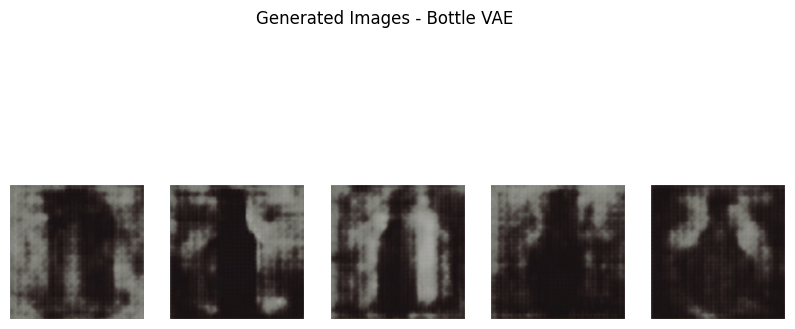

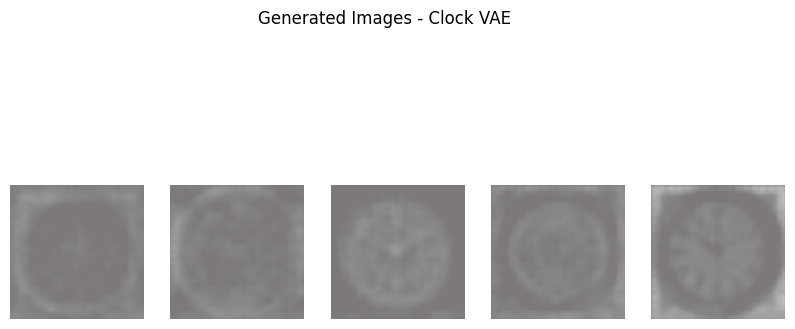

In [13]:
# Celda 6: Visualización y registro de imágenes generadas en WandB

def display_generated_images(gen_images, title):
    plt.figure(figsize=(10, 5))
    n = min(5, gen_images.shape[0])
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(gen_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualización para Motorcycle VAE
display_generated_images(gen_images_bottle, "Generated Images - Bottle VAE")

# Visualización para Clock VAE
display_generated_images(gen_images_clock, "Generated Images - Clock VAE")

# Registro de imágenes en WandB
run_vis = wandb.init(project="VAE + DAE", name="Generated_Images", reinit=True)
wandb.log({
    "Generated_Images_Bottle": [wandb.Image(img) for img in gen_images_bottle[:5]],
    "Generated_Images_Clock": [wandb.Image(img) for img in gen_images_clock[:5]]
})
wandb.finish()